<h1><center></center></h1>

![](https://www.asme.org/getmedia/86f7ec3b-0483-4660-bc59-b1fb061b0700/050520_computational-lung-model-may-guide-how-ventilators-are-usedlungs-3d_hero.jpg?width=920&height=720&ext=.jpg)

<p style='text-align: right;'><span style="color: #0098f3; font-family: Segoe UI; font-size: 0.7em; font-weight: 300;">Image Source: https://www.asme.org/topics-resources/content/computational-lung-model-may-guide-how-ventilators-are-used</span></p>

<p style='text-align: center;'><span style="color: #0098f3; font-family: Segoe UI; font-size: 2.5em; font-weight: 300;">COVID-19. Детекция Атипичной пневмонии по рентгеновским снимкам</span></p>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:blue; border:0; color:white' role="tab" aria-controls="home"><center>[Ноутбук Анализа Данных]</center></h2>

# Введение

- В настоящее время существуют несколько способов диагностирования COVID-19. Наиболее распространенные методы:
    - с помощью полимеразной цепной реакции для обнаружения генетического материала вируса.
    - рентген грудной клетки. 
  Однако может пройти несколько часов, а иногда и дней, прежде чем результаты молекулярных тестов могут быть получены. Напротив, рентг грудной клетки можно получить за считанные минуты.
  
- В этом проекте я попытаюсь определить и локализовать аномалии в грудных клетках людей (на рентген снимках). В частности, попробуем классифицировать различного рода пневмонии.(Атипичная(COVID-19) и типичная)

- Этот проект может помочь докторам более быстро и точно диагностировать тысячи пациентов с подозрением на это заболевание.


Данные взяты из [kaggle](https://www.kaggle.com/c/siim-covid19-detection/data)

## Файлы данных

 - **Train folder**: включает 6334 скана грудной клетки в формате DICOM.
 - Все изображения хранятся в путях с формой  *study/series/image*
      - **study**: ID иследования напрямую связан с прогнозом на уровне исследования
      - **image:** - ID изображения
  - **Test folder**: Тут все ясно
  - **Train_study_level.csv**: Метаданные с строкой для каждого исследования, включая правильный лэйбл
  - **train_image_level.csv**: Метаданные уровня тренировочного изображения, с одной строкой для каждого изображения, включая правильные метки и  рамки в формате словаря. Некоторые изображения как в тесте, так и в трэйне имеют несколько рамок.

## Колонки файлов .CSV

**train_study_level.csv**
   - id:unique study identifier
   - **Negative for Pneumonia**: 1, если исследование на пневмонию отрицательное, 0 в противном случае
   - **Typical Appearance**: 1, если исследование имеет типичный вид, 0 в противном случае
   - **Indeterminate Appearance**:  1, если исследование имеет промежуточный вид, 0 в противном случае
   - **Atypical Appearance**: 1, если исследование имеет Атипичный вид, 0 в противном случае
   

1. Normal chest X-ray(Negative). - Рентген грудной клетки нередко бывает нормальным на ранней стадии заболевания, поэтому нормальный рентген не исключает инфекции. 

2. Typical Appearance - Типичные признаки заболевания на снимках. Они включают ретикулярный узор, матовые помутнения и уплотнения с округлой морфологией и сливным или пятнистым мультифокальным распределением. Распространение обычно двустороннее и периферическое, с преобладанием в нижних полях.

3. Indeterminate. Неопределенные признаки. Неопределенные признаки, которые могут иметь место в случаях пневмонии COVID-19, могут иметь другие причины. К ним относятся уплотнения и помутнения матового стекла с односторонним, центральным или верхнедолевым распределением. Дифференциальный диагноз включает другие инфекции и альвеолярный отек. 

4. Atypical Appearance.  Атипичные признаки, необычные, не связываемые с COVID-19.  К ним относятся дольчатая консолидация, узелки или образования в легких, милиарный паттерн, кавитация и плевральный выпот, о которых сообщалось только у 3% пациентов и которые более типичны для запущенного заболевания. 

# Импорт Библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import cv2
import seaborn as sns
import warnings
from sklearn import preprocessing


import config
import plottings
from med_vis import dicom2array, plot_imgs

In [2]:
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)
plt.style.use('ggplot')

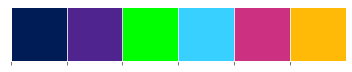

In [3]:
# Set project colors
colors = ['#001c57', '#50248f', '#00ff00', '#38d1ff','#cc3181','#FFBA08']
sns.palplot(sns.color_palette(colors))

# Загрузка данных

### train_study_level.csv

In [4]:
train_study_df = pd.read_csv(config.TRAIN_STUDY_CSV)

# Re-name cols of df
cols = {'Negative for Pneumonia': 'negative',
        'Typical Appearance': 'typical',
        'Indeterminate Appearance': 'indeterminate',
        'Atypical Appearance': 'atypical'}

train_study_df = train_study_df.rename(columns = cols)
train_study_df.info()
train_study_df.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             6054 non-null   object
 1   negative       6054 non-null   int64 
 2   typical        6054 non-null   int64 
 3   indeterminate  6054 non-null   int64 
 4   atypical       6054 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 236.6+ KB


id  negative  typical  indeterminate  atypical
3739  9f0ec4c9eba3_study         0        0              1         0
3488  952f04d9cfcc_study         0        1              0         0
3712  9da3efcced2e_study         0        1              0         0
4637  c3835f6d361a_study         0        0              1         0

Всего 6054 вхождения. На первый взгляд, пропусков в даных нет.

Создадим колонку, где обозначим лэйбл вхождения


In [5]:
train_study_df['label_y'] = 'negative'
train_study_df.loc[train_study_df['typical'] == 1, 'label_y'] = 'typical'
train_study_df.loc[train_study_df['indeterminate'] == 1, 'label_y'] = 'indeterminate'
train_study_df.loc[train_study_df['atypical'] == 1, 'label_y'] = 'atypical'
train_study_df.sample(5)

id  negative  typical  indeterminate  atypical  \
2514  6ce61dcd9de9_study         0        0              1         0   
2087  5a9ef6342497_study         1        0              0         0   
2372  678ff202ffd6_study         1        0              0         0   
5355  e1f5682712bd_study         0        1              0         0   
3433  92e2158a09b7_study         0        1              0         0   

            label_y  
2514  indeterminate  
2087       negative  
2372       negative  
5355        typical  
3433        typical

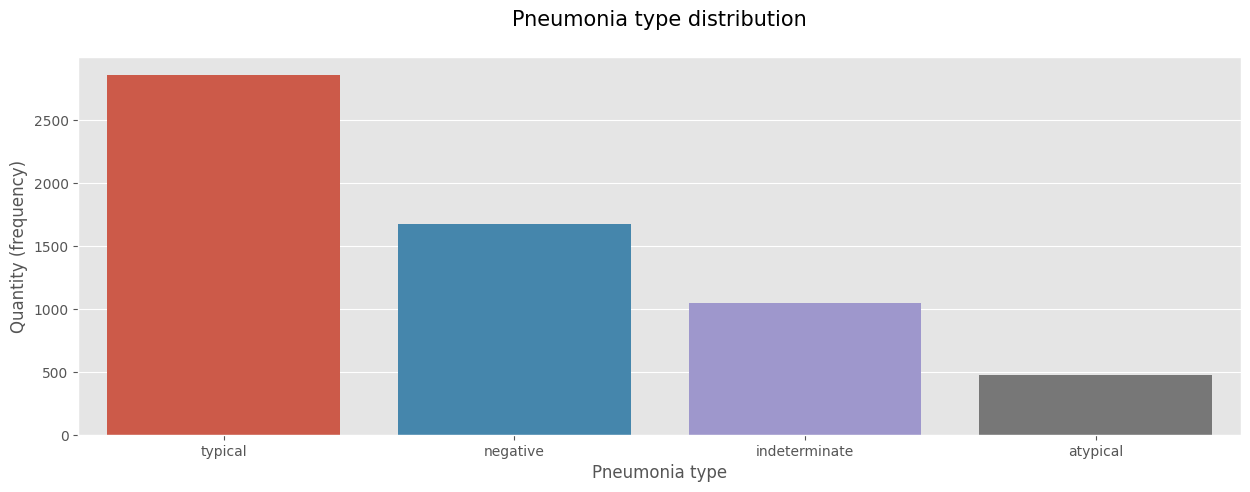

typical          47.158903
negative         27.684176
indeterminate    17.327387
atypical          7.829534
Name: label_y, dtype: float64

In [6]:
plottings.plot_countplot(train_study_df,'label_y','Pneumonia type')
train_study_df['label_y'].value_counts(normalize=True)*100

Видим, что данные не сбалансированны

### train_image_level.csv

In [7]:
train_image_df = pd.read_csv(config.TRAIN_IMAGE_CSV)
train_image_df.info()
train_image_df.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                6334 non-null   object
 1   boxes             4294 non-null   object
 2   label             6334 non-null   object
 3   StudyInstanceUID  6334 non-null   object
dtypes: object(4)
memory usage: 198.1+ KB


id                                              boxes  \
4076  a650491c7276_image  [{'x': 2061.60015, 'y': 788.79998, 'width': 56...   
1950  4f6b571c20f0_image                                                NaN   
2129  5687abeb8010_image  [{'x': 1860.2, 'y': 736.85996, 'width': 843.47...   
1579  406933b91104_image  [{'x': 501.8667, 'y': 1227.86664, 'width': 328...   

                                                  label StudyInstanceUID  
4076  opacity 1 2061.60015 788.79998 2625.60015 1503...     91107b116bec  
1950                                     none 1 0 0 1 1     0e76983343a5  
2129  opacity 1 1860.2 736.85996 2703.67998 2179.580...     abe76d6fc929  
1579  opacity 1 501.8667 1227.86664 829.8667 1479.86...     fc4a3e5f80d5

Видно,что в колонке boxes есть пропуски

в колонке *label* формат выглядит следующим образом: [Class ID] [confidence score] [bounding box]

    - **Class ID:** Есть ли затемнение или нет
    - **Confidence score:** уверенность модели нейронной сети. Если NONE, то confidence равна 1. 
    - **Bounding box**: формат xmin ymin xmax ymax. Если идентификатор класса отсутствует, ограничивающая рамка - 1 0 0 1 1.  

In [8]:
# Вытащим из колонки Lasbel только class Id
train_image_df['class'] = train_image_df.label.apply(lambda x: x.split()[0])

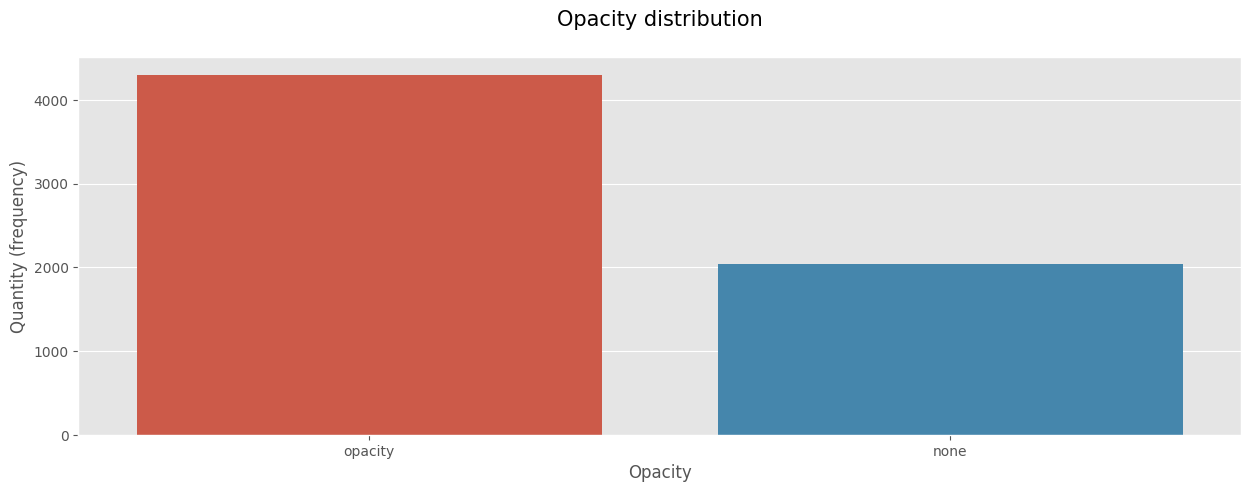

In [9]:
plottings.plot_countplot(train_image_df, 'class', 'Opacity')

Вытащим координаты  Bounding Boxs в отдельные колонки

In [10]:
train_image_df['x_min'] = train_image_df.label.apply(lambda x: float(x.split()[2]))
train_image_df['y_min'] = train_image_df.label.apply(lambda x: float(x.split()[3]))
train_image_df['x_max'] = train_image_df.label.apply(lambda x: float(x.split()[4]))
train_image_df['y_max'] = train_image_df.label.apply(lambda x: float(x.split()[5]))
train_image_df.sample(3)

id                                              boxes  \
3601  91abd96780d5_image  [{'x': 40.88, 'y': 194.66667, 'width': 1086.24...   
4227  aceaa1504385_image  [{'x': 441.60004, 'y': 1401.59993, 'width': 60...   
72    027473c590c1_image                                                NaN   

                                                  label StudyInstanceUID  \
3601  opacity 1 40.88 194.66667 1127.1200000000001 1...     9d8fb5abccc3   
4227  opacity 1 441.60004 1401.59993 1043.20002 2259...     19e8f5ead404   
72                                       none 1 0 0 1 1     4e9eb654f451   

        class      x_min       y_min       x_max       y_max  
3601  opacity   40.88000   194.66667  1127.12000  1829.86667  
4227  opacity  441.60004  1401.59993  1043.20002  2259.19978  
72       none    0.00000     0.00000     1.00000     1.00000

Вернемся к **train_study_level.csv** и почистим колонку с id

In [11]:
train_study_df['StudyInstanceUID'] = train_study_df['id'].apply(lambda x: x.replace('_study', ''))
train_study_df.drop('id',axis=1,inplace=True)

In [12]:
# Объеденим два датафрейма
train_image_df = train_image_df.merge(train_study_df, on='StudyInstanceUID')

In [13]:
train_image_df.sample(3).T

3770  \
id                                               926c8e7cd1cd_image   
boxes             [{'x': 450.87779, 'y': 816.66667, 'width': 891...   
label             opacity 1 450.87779 816.66667 1342.21112 2174....   
StudyInstanceUID                                       535f8c7a5191   
class                                                       opacity   
x_min                                                     450.87779   
y_min                                                     816.66667   
x_max                                                    1342.21112   
y_max                                                    2174.66667   
negative                                                          0   
typical                                                           1   
indeterminate                                                     0   
atypical                                                          0   
label_y                                                     typical   

                                                               4622  \
id                                               b7da62bf0a1a_image   
boxes             [{'x': 1959.37496, 'y': 973.64586, 'width': 59...   
label             opacity 1 1959.37496 973.64586 2552.9167 1780....   
StudyInstanceUID                                       7d2ca42f0906   
class                                                       opacity   
x_min                                                    1959.37496   
y_min                                                     973.64586   
x_max                                                     2552.9167   
y_max                                                    1780.31255   
negative                                                          0   
typical                                                           1   
indeterminate                                                     0   
atypical                                                          0   
label_y                                                     typical   

                                                               2349  
id                                               66b86b95c76a_image  
boxes             [{'x': 1972.63585, 'y': 1378.33253, 'width': 6...  
label             opacity 1 1972.63585 1378.33253 2608.175379999...  
StudyInstanceUID                                       26648048b098  
class                                                       opacity  
x_min                                                    1972.63585  
y_min                                                    1378.33253  
x_max                                                    2608.17538  
y_max                                                    1591.16437  
negative                                                          0  
typical                                                           0  
indeterminate                                                     0  
atypical                                                          1  
label_y                                                    atypical

In [14]:
train_image_df['integer_label'] = train_image_df['label_y']

In [15]:
# Закодируем 'integer_label'
le = preprocessing.LabelEncoder()
train_image_df['integer_label'] = le.fit_transform(train_image_df['integer_label'])
train_image_df.T

0     \
id                                               000a312787f2_image   
boxes             [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
label             opacity 1 789.28836 582.43035 1815.94498 2499....   
StudyInstanceUID                                       5776db0cec75   
class                                                       opacity   
x_min                                                     789.28836   
y_min                                                     582.43035   
x_max                                                    1815.94498   
y_max                                                    2499.73327   
negative                                                          0   
typical                                                           1   
indeterminate                                                     0   
atypical                                                          0   
label_y                                                     typical   
integer_label                                                     3   

                                1     \
id                000c3a3f293f_image   
boxes                            NaN   
label                 none 1 0 0 1 1   
StudyInstanceUID        ff0879eb20ed   
class                           none   
x_min                            0.0   
y_min                            0.0   
x_max                            1.0   
y_max                            1.0   
negative                           1   
typical                            0   
indeterminate                      0   
atypical                           0   
label_y                     negative   
integer_label                      2   

                                                               2     \
id                                               0012ff7358bc_image   
boxes             [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
label             opacity 1 677.42216 197.97662 1545.21983 1197....   
StudyInstanceUID                                       9d514ce429a7   
class                                                       opacity   
x_min                                                     677.42216   
y_min                                                     197.97662   
x_max                                                    1545.21983   
y_max                                                    1197.75876   
negative                                                          0   
typical                                                           1   
indeterminate                                                     0   
atypical                                                          0   
label_y                                                     typical   
integer_label                                                     3   

                                                               3     \
id                                               001398f4ff4f_image   
boxes             [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
label               opacity 1 2729 2181.33331 3677.00012 2785.33331   
StudyInstanceUID                                       28dddc8559b2   
class                                                       opacity   
x_min                                                        2729.0   
y_min                                                    2181.33331   
x_max                                                    3677.00012   
y_max                                                    2785.33331   
negative                                                          0   
typical                                                           0   
indeterminate                                                     0   
atypical                                                          1   
label_y                                                    atypical   
integer_label                                                     0   

           

Почистим колонку id

In [16]:
train_image_df['id_image'] = train_image_df['id']
train_image_df['id'] = train_image_df['id'].apply(lambda x: x.replace('_image', ''))
train_image_df.head(3).T

0  \
id                                                     000a312787f2   
boxes             [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
label             opacity 1 789.28836 582.43035 1815.94498 2499....   
StudyInstanceUID                                       5776db0cec75   
class                                                       opacity   
x_min                                                     789.28836   
y_min                                                     582.43035   
x_max                                                    1815.94498   
y_max                                                    2499.73327   
negative                                                          0   
typical                                                           1   
indeterminate                                                     0   
atypical                                                          0   
label_y                                                     typical   
integer_label                                                     3   
id_image                                         000a312787f2_image   

                                   1  \
id                      000c3a3f293f   
boxes                            NaN   
label                 none 1 0 0 1 1   
StudyInstanceUID        ff0879eb20ed   
class                           none   
x_min                            0.0   
y_min                            0.0   
x_max                            1.0   
y_max                            1.0   
negative                           1   
typical                            0   
indeterminate                      0   
atypical                           0   
label_y                     negative   
integer_label                      2   
id_image          000c3a3f293f_image   

                                                                  2  
id                                                     0012ff7358bc  
boxes             [{'x': 677.42216, 'y': 197.97662, 'width': 867...  
label             opacity 1 677.42216 197.97662 1545.21983 1197....  
StudyInstanceUID                                       9d514ce429a7  
class                                                       opacity  
x_min                                                     677.42216  
y_min                                                     197.97662  
x_max                                                    1545.21983  
y_max                                                    1197.75876  
negative                                                          0  
typical                                                           1  
indeterminate                                                     0  
atypical                                                          0  
label_y                                                     typical  
integer_label                                                     3  
id_image                                         0012ff7358bc_image

UPD
Во время тренировки модели было обнаружено, что есть дубликаты изображений без аннотаций.

Исправим это

In [17]:
# add StudyInstanceUID_count column
group_col = 'StudyInstanceUID'
df=pd.DataFrame(train_image_df.groupby(group_col)['id'].count())
df.columns = [f'{group_col}_count']
train_image_df = train_image_df.merge(df.reset_index(), on=group_col)
one_study_multi_image_df = train_image_df[train_image_df[f'{group_col}_count'] > 1]
print(len(one_study_multi_image_df))
train_image_df = train_image_df[train_image_df[f'{group_col}_count'] == 1] # delete 'StudyInstanceUID_count > 1' data
one_study_multi_image_df.head()

512


id                                              boxes  \
22  00c1515729a8                                                NaN   
23  cada5310214b  [{'x': 981.75034, 'y': 256.08181, 'width': 225...   
25  00e3a7e91a34                                                NaN   
26  0d4d6acc9ed3                                                NaN   
27  93a881fb3292                                                NaN   

                                                label StudyInstanceUID  \
22                                     none 1 0 0 1 1     1a58b43cf286   
23  opacity 1 981.75034 256.08181 1207.54099 765.2...     1a58b43cf286   
25                                     none 1 0 0 1 1     74ba8f2badcb   
26                                     none 1 0 0 1 1     74ba8f2badcb   
27                                     none 1 0 0 1 1     74ba8f2badcb   

      class      x_min      y_min       x_max      y_max  negative  typical  \
22     none    0.00000    0.00000     1.00000    1.00000         0        1   
23  opacity  981.75034  256.08181  1207.54099  765.26287         0        1   
25     none    0.00000    0.00000     1.00000    1.00000         1        0   
26     none    0.00000    0.00000     1.00000    1.00000         1        0   
27     none    0.00000    0.00000     1.00000    1.00000         1        0   

    indeterminate  atypical   label_y  integer_label            id_image  \
22              0         0   typical              3  00c1515729a8_image   
23              0         0   typical              3  cada5310214b_image   
25              0         0  negative              2  00e3a7e91a34_image   
26              0         0  negative              2  0d4d6acc9ed3_image   
27              0         0  negative              2  93a881fb3292_image   

    StudyInstanceUID_count  
22                       2  
23                       2  
25                       4  
26                       4  
27                       4

In [19]:
train_image_df['StudyInstanceUID_count'].unique()

array([1])

In [32]:
# Сохраним результат
train_image_df.to_csv(f"{config.DATA_ROOT}/train_image_df.csv")

Напечатаем распределения наличия пневмоний по типам затемнений.

Напомню. 1 - пневмония не деагностирована

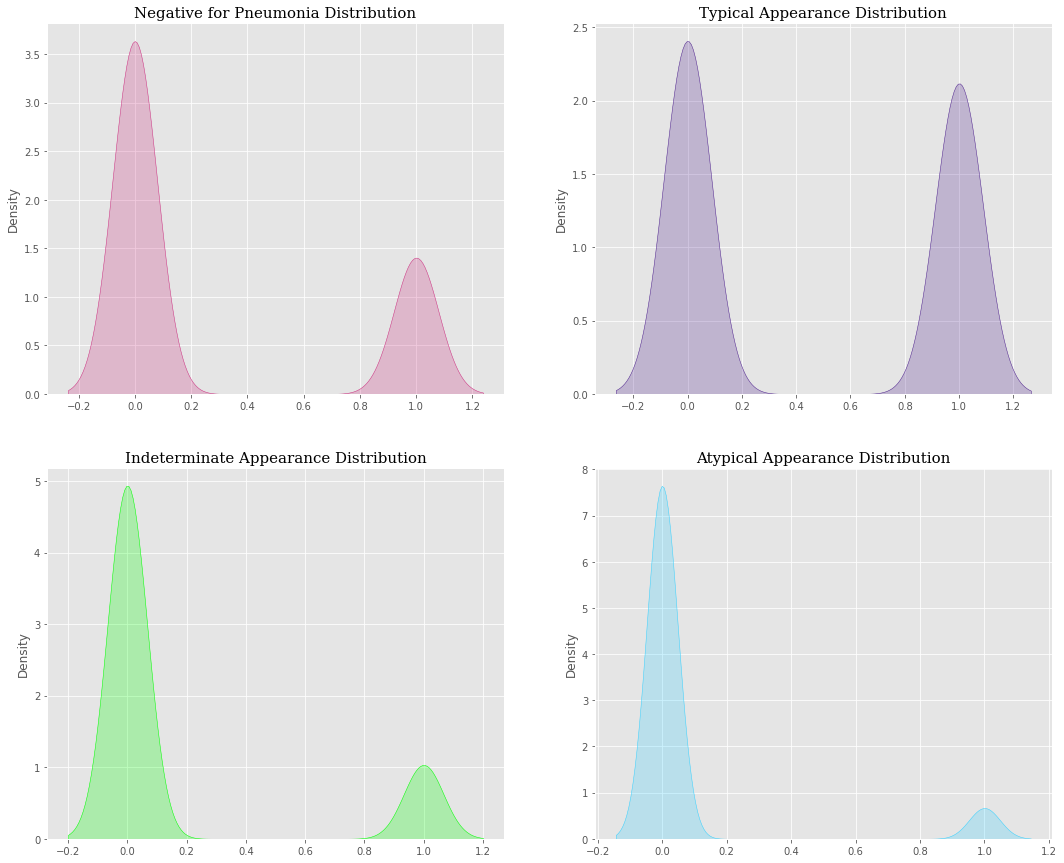

In [21]:
fig, ax = plt.subplots(2,2,figsize=(18,15))
sns.kdeplot(train_image_df["negative"], shade=True,ax=ax[0,0],color=colors[4])
ax[0,0].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=15)
ax[0,0].set(xlabel=None)
sns.kdeplot(train_image_df["typical"], shade=True,ax=ax[0,1],color=colors[1])
ax[0,1].set_title("Typical Appearance Distribution",font="Serif", fontsize=15)
ax[0,1].set(xlabel=None)
sns.kdeplot(train_image_df["indeterminate"], shade=True,ax=ax[1,0],color=colors[2])
ax[1,0].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=15)
ax[1,0].set(xlabel=None)
sns.kdeplot(train_image_df["atypical"], shade=True,ax=ax[1,1],color=colors[3])
ax[1,1].set_title("Atypical Appearance Distribution",font="Serif", fontsize=15)
ax[1,1].set(xlabel=None)
plt.show()

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:blue; border:0; color:white' role="tab" aria-controls="home"><center>Визуаизация Рентгеновских Снимков</center></h2>

## [TRAIN X-RAY]

In [22]:
train_files = sorted(list(Path(f'{config.DATA_ROOT}/train').rglob('*dcm')))
print(f'Total Number of train files: {len(train_files)}')

Total Number of train files: 6334


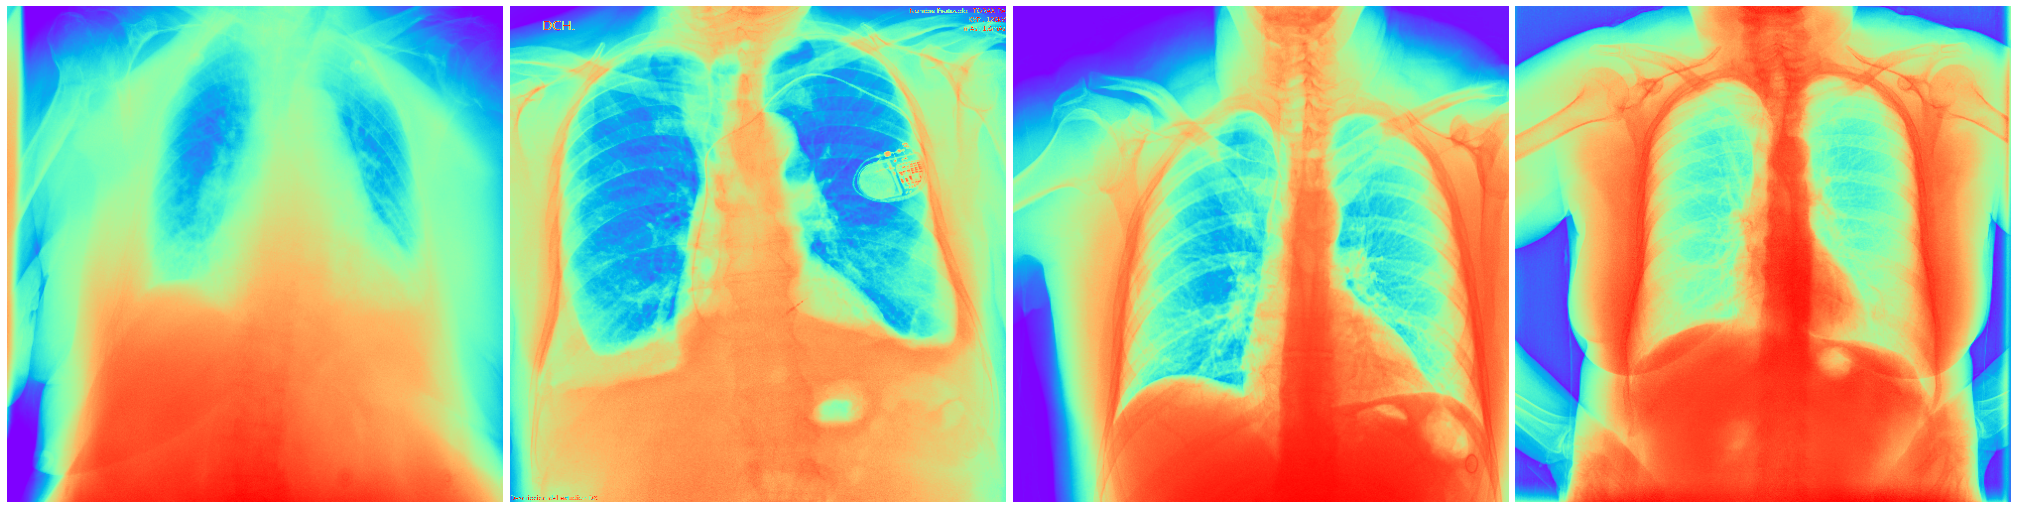

In [31]:
imgs = [dicom2array(path) for path in train_files[:4] ]
plot_imgs(imgs, cmap='rainbow')#cmap='plasma')

## Напечатаем снимки с bounding box

Пусть цвета будут:

### <span style="color:#50248f">Typical Appearance</span>
### <span style="color:#cc3181">Indeterminate Appearance</span>
### <span style="color:#FFBA08">Atypical Appearance</span>

### Все классы

In [24]:
class_names = ['typical', 'indeterminate', 'atypical'] # 3 positive classes
unique_classes = np.unique(train_image_df[class_names].values, axis=0)
unique_classes

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

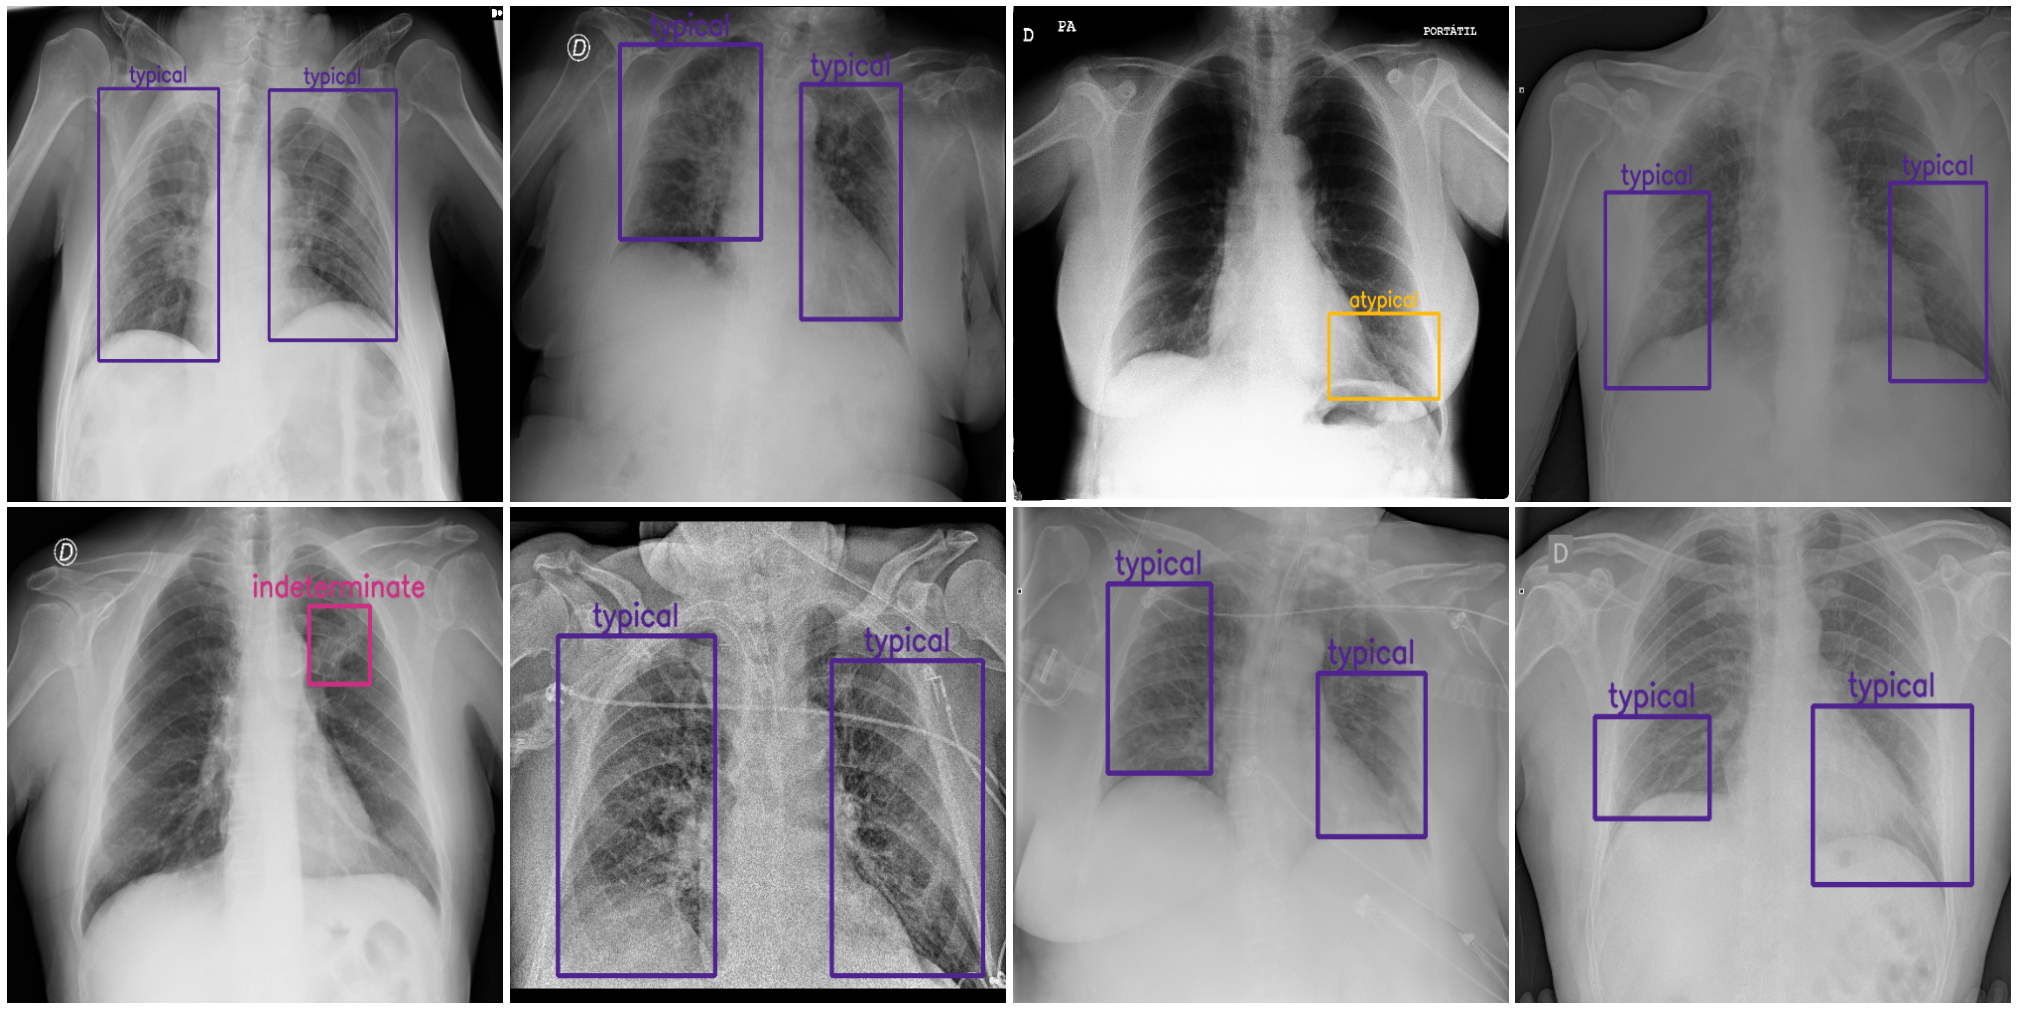

In [25]:
imgs = []
label2color = {
    '[1, 0, 0]': [80, 36, 143], # Typical Appearance RGB
    '[0, 1, 0]': [204, 49, 129], # Indeterminate Appearance RGB
    '[0, 0, 1]': [255, 186, 8], # Atypical Appearance RGB
    '[0, 0, 0]': None, # negative
}
label2target = {
    '[1, 0, 0]': 'typical',
    '[0, 1, 0]': 'indeterminate',
    '[0, 0, 1]': 'atypical'
}
thickness = 3
scale = 5
FONT = cv2.FONT_HERSHEY_SIMPLEX; FONT_SCALE = 1; FONT_THICKNESS = 2; FONT_LINE_TYPE = cv2.LINE_AA;

for _, row in train_image_df[train_image_df['negative']==0].iloc[:8].iterrows():
    study_id = row['StudyInstanceUID']
    # Извлечем ID изображения и вытащим путь к этому изображению
    img_path = glob(f'{config.DATA_ROOT}/train/{study_id}/*/*')[0]
    # Конвертируем dcim в numpy array
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    # Вытащим класс затемнения(Typical, atypical etc)
    claz = row[class_names].values
    # Извлечем код для цвета boundary box
    color = label2color[str(claz.tolist())]
    target = label2target[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []

    text_width, text_height = cv2.getTextSize(target, FONT, FONT_SCALE, FONT_THICKNESS)[0]
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
        )
        box_width = int(box[2]) - int(box[0])
        img = cv2.putText(img, target, (int(box[0])-(text_width-box_width)//2, int(box[1])-10),
                        FONT, FONT_SCALE, color, FONT_THICKNESS, FONT_LINE_TYPE)
    img = cv2.resize(img, (500,500))
    imgs.append(img)

plot_imgs(imgs, cmap=None)


### <span style="color:#50248f">Typical Appearance Only</span>

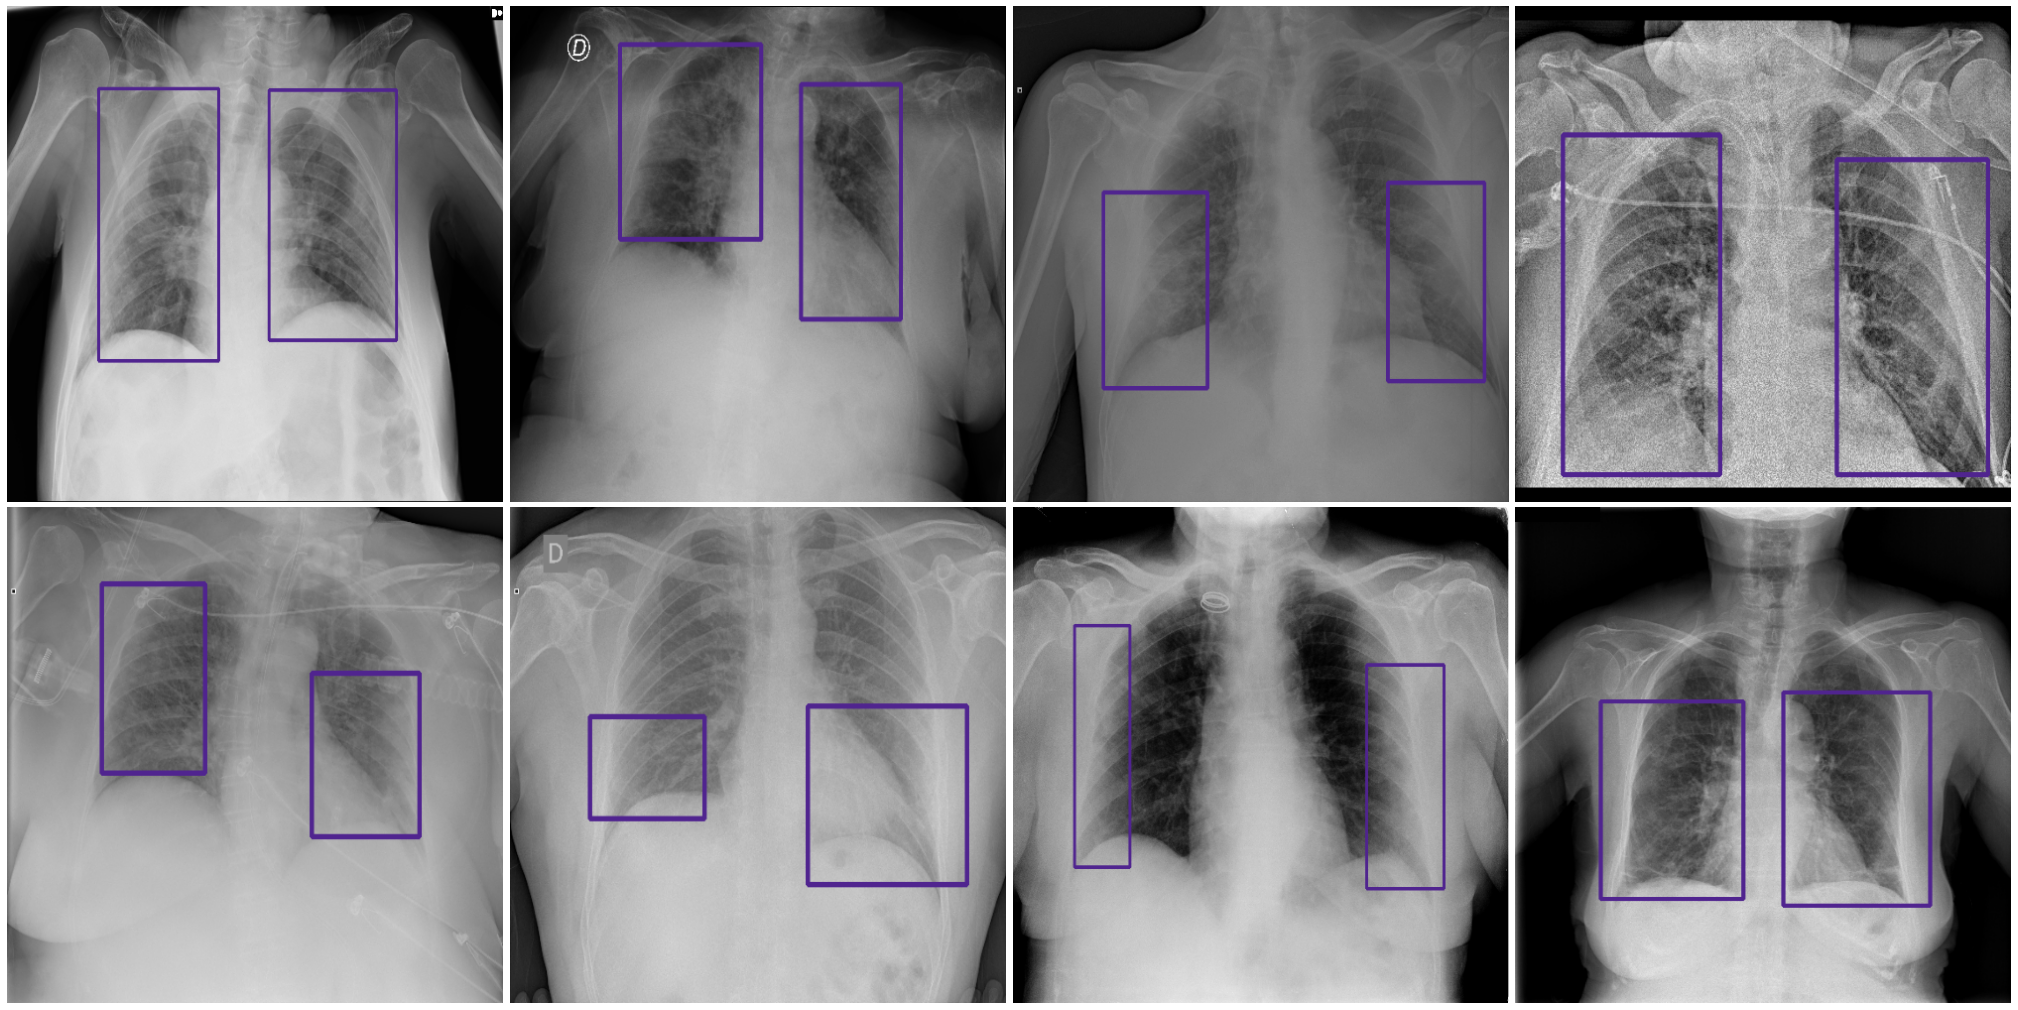

In [26]:
imgs = []
thickness = 3
scale = 5

for _, row in train_image_df[train_image_df['typical'] == 1].iloc[:8].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{config.DATA_ROOT}/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)

    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []

    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)

plot_imgs(imgs, cmap=None)

### <span style="color:#cc3181">Indeterminate Appearance Only</span>

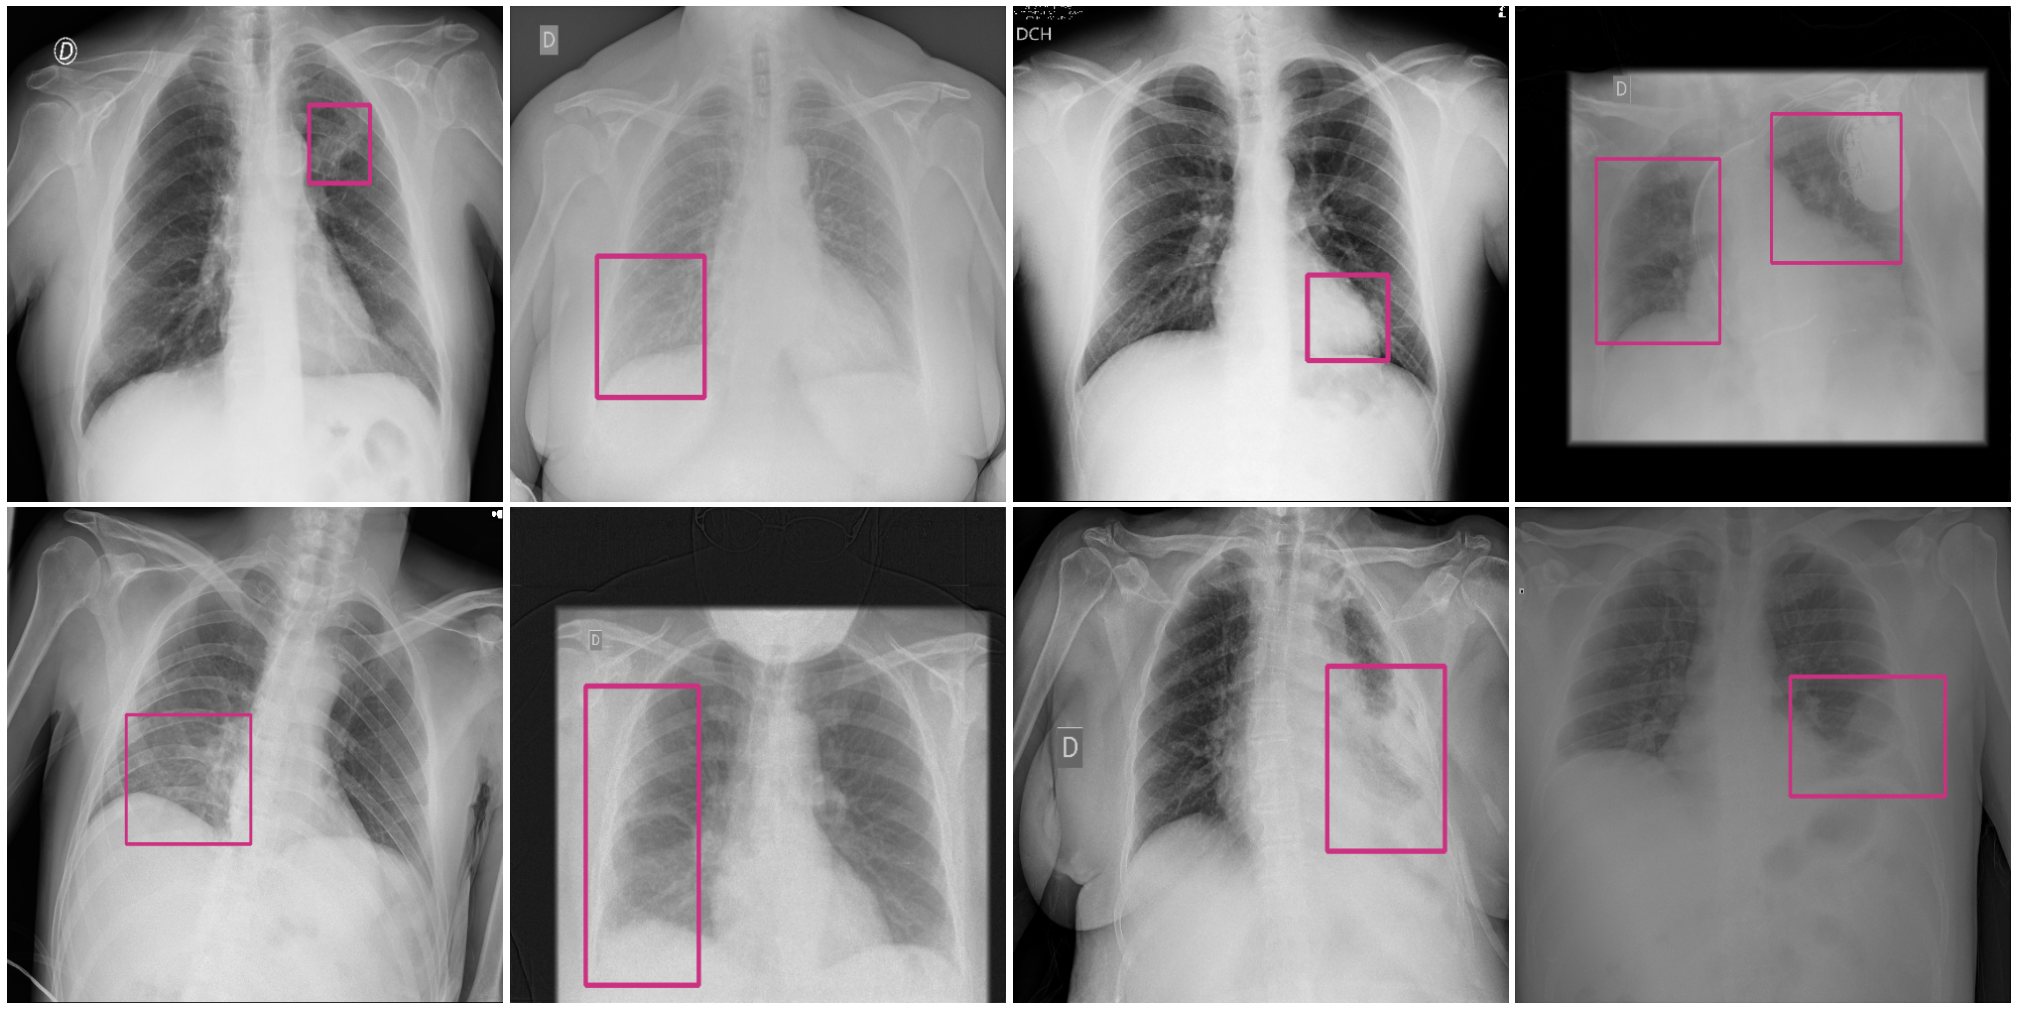

In [27]:
imgs = []
thickness = 3
scale = 5

for _, row in train_image_df[train_image_df['indeterminate'] == 1].iloc[:8].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{config.DATA_ROOT}/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)

    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []

    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)

plot_imgs(imgs, cmap=None)

### <span style="color:#FFBA08">Atypical Appearance Only</span>

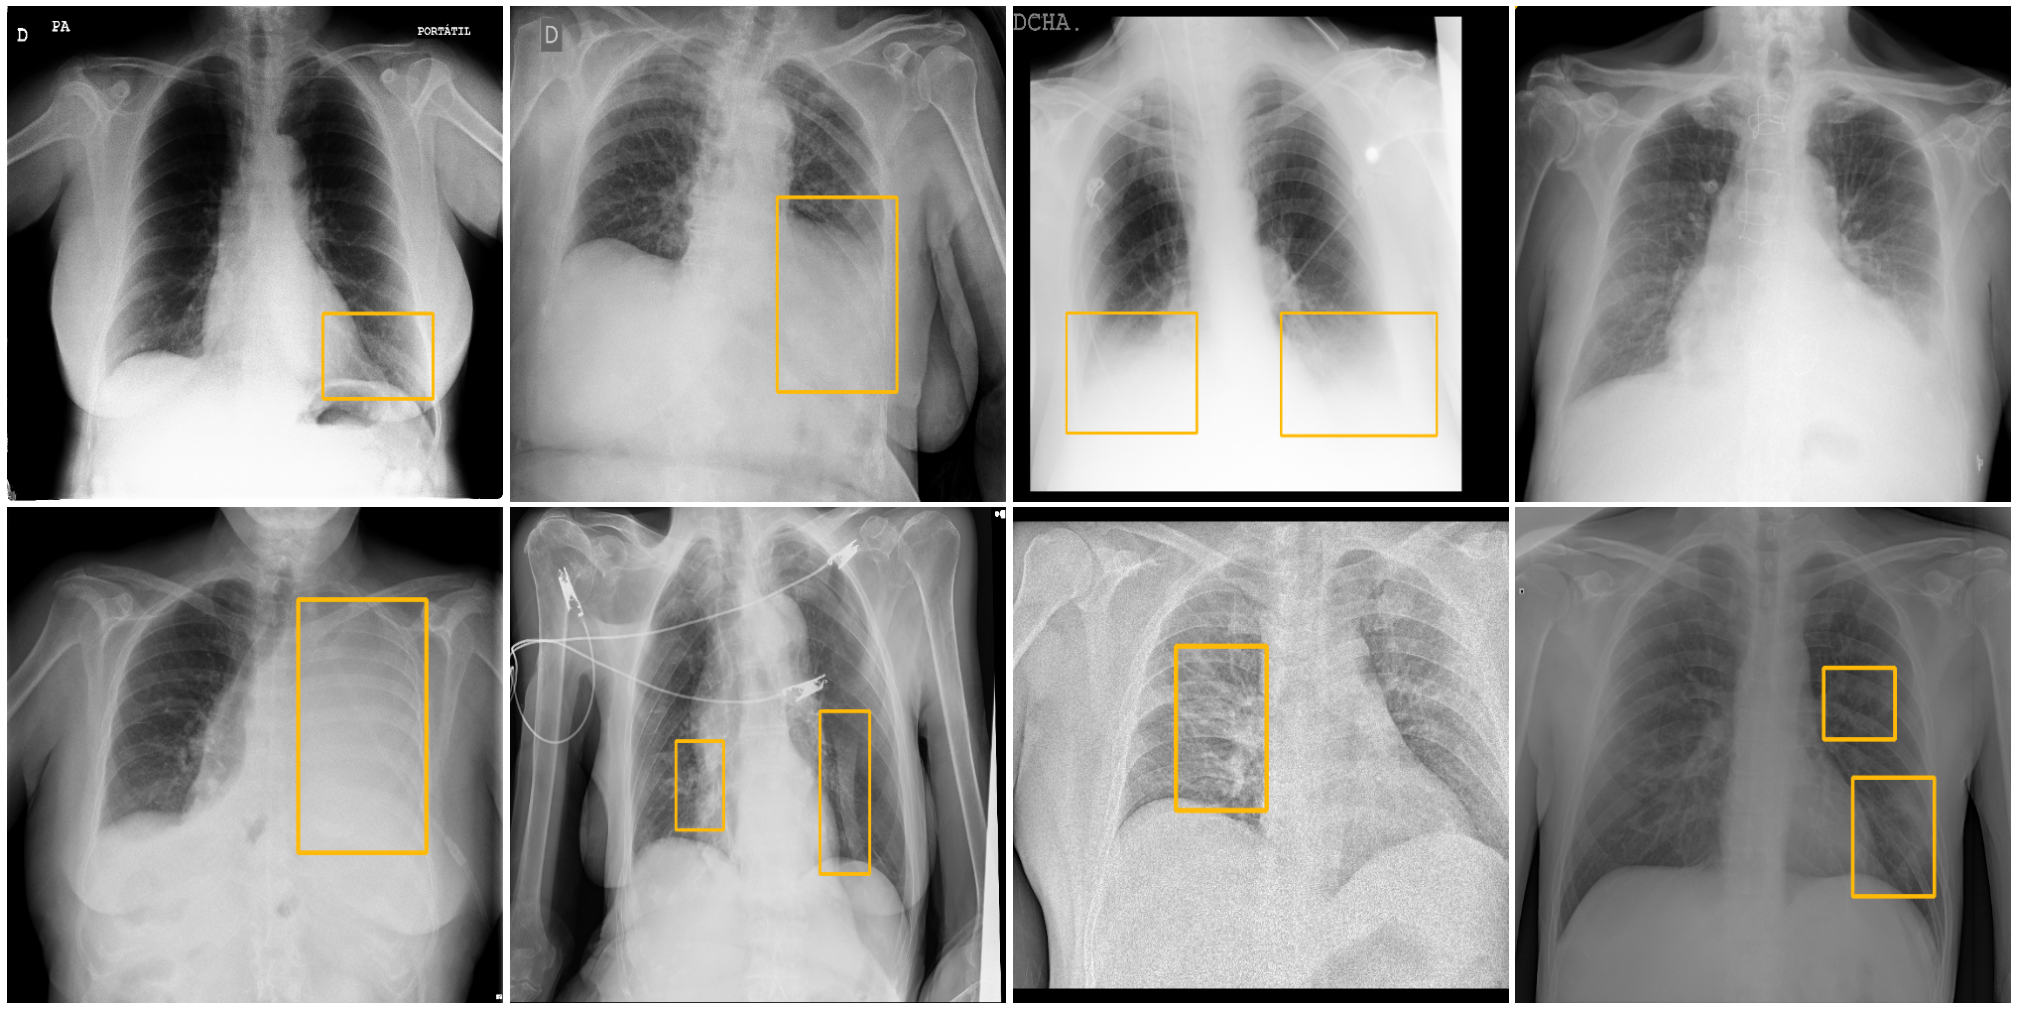

In [28]:
imgs = []
thickness = 3
scale = 5

for _, row in train_image_df[train_image_df['atypical'] == 1].iloc[:8].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{config.DATA_ROOT}/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)

    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []

    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)

plot_imgs(imgs, cmap=None)

In [ ]:
c